In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from bnr_ml.nnet import layers
from bnr_ml.objectdetect import yolo
from bnr_ml.nnet.updates import momentum
import theano
from theano import tensor as T
from collections import OrderedDict
from tqdm import tqdm

import lasagne
import lasagne.layers as layers

import pickle as pk

import pdb

/Library/Python/2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
def gen_num_objs(max_obj):
    return int(1 + max_obj * np.random.rand())

In [3]:
def gen_classes(num_obj, num_class):
    return np.random.randint(num_class, size=(num_obj,))

In [4]:
def gen_circle(shape):
#     pdb.set_trace()
    row, col = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    row, col = row.astype(np.float64), col.astype(np.float64)
    row = (row - row.shape[1] / 2) / (row.shape[1] / 2)
    col = (col - col.shape[0] / 2) / (col.shape[0] / 2)
    
    
    im = np.zeros(shape + (1,))
    for i in range(im.shape[2]):
        in_ellipse = (row**2 + col**2) < 1
#         im[:,:,i][in_ellipse] = (np.random.gamma(.7) + np.random.gamma(.4) * np.random.randn(*shape))[in_ellipse]
        im[:,:,i][in_ellipse] = np.ones(shape)[in_ellipse]
    im[im < 0] = 0.
    im[im >= 1] = 1.
    return im

In [5]:
def gen_rect(shape):
    im = np.zeros(shape + (3,))
    for i in range(3):
        im[:,:,i] = (np.random.gamma(.7) + np.random.gamma(.4) * np.random.randn(*shape))
    im[im < 0] = 0.
    im[im > 1] = 1.
    return im

In [6]:
def gen_triangle(shape):
    row, col = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    row, col = row.astype(np.float64), col.astype(np.float64)
    row = row / row.shape[1]
    col = col / col.shape[0]
    
    
    im = np.zeros(shape + (1,))
    if np.random.rand() < .5:
        in_triangle = row + col < 1
    else:
        in_triangle = row + col > 1
    for i in range(im.shape[2]):
        im[:,:,i][in_triangle] = np.ones(shape)[in_triangle]
#         im[:,:,i][in_triangle] = (np.random.gamma(.7) + np.random.gamma(.4) * np.random.randn(*shape))[in_triangle]
    im[im < 0] = 0.
    im[im >= 1] = 1.
    return im

In [7]:
def gen_pos_shape(min_shape, im_shape):
    shape = (
        int(min_shape[0] + (im_shape[0] - min_shape[0]) * np.random.rand()),
        int(min_shape[1] + (im_shape[1] - min_shape[1]) * np.random.rand())
    )
    pos = (
        int((im_shape[0] - shape[0]) * np.random.rand()),
        int((im_shape[1] - shape[1]) * np.random.rand())
    )
    return shape, pos

In [8]:
def gen_scene(max_obj, num_class, min_shape, im_shape):
    num_obj = gen_num_objs(max_obj)
    classes = gen_classes(num_obj, num_class)
    im = np.random.gamma(.4) * np.random.randn(*(im_shape + (1,)))
    im[im < 0] = 0.
    im[im > 1] = 1.
    y = np.zeros((4 + num_class,))
    
    for cls in classes:
        shape, pos = gen_pos_shape(min_shape, im_shape)
        if cls == 0:
            shp = gen_circle(shape)
        elif cls == 1:
            shp = gen_triangle(shape)
        elif cls == 2:
            shp = gen_triangle(shape)
        else:
            pass
        im[pos[0]:pos[0]+shape[0],pos[1]:pos[1]+shape[1],:] += shp
        y[:4] = pos + shape
        y = y.astype(np.float64)
        y[[0,2]] /= im_shape[0]
        y[[1,3]] /= im_shape[1]
        y[-num_class + cls] += 1.
    return im / np.max(im), y

In [9]:
def gen_dataset(size, shape):
    X, y = np.zeros((size,1) + shape), np.zeros((size,4+2))
    for i in range(size):
        dat = gen_scene(1, 2, (20, 20), shape)
        X[i], y[i] = dat[0].swapaxes(2,1).swapaxes(1,0), dat[1]
    return X, y

In [53]:
X,y = gen_dataset(500, (100,100))

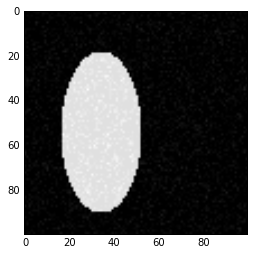

[ 0.18  0.16  0.72  0.36]


In [15]:
N = np.int_(X.shape[0] * np.random.rand())
plt.imshow(X[N,0], 'gray')
plt.show()

print y[N,:4]

In [11]:
input = T.tensor4('input')

In [12]:
l1 = layers.InputLayer((None,1,100,100), input_var=input)
l2 = layers.Conv2DLayer(
    l1,
    8,
    (3,3)
)
l3 = layers.Conv2DLayer(
    l2,
    8,
    (3,3)
)
l4 = layers.Pool2DLayer(
    l3,
    (3,3)
)
l5 = layers.Conv2DLayer(
    l4,
    16,
    (3,3)
)
l6 = layers.Conv2DLayer(
    l5,
    16,
    (3,3)
)
l7 = layers.Pool2DLayer(
    l6,
    (3,3)
)

le1 = layers.Conv2DLayer(
    l7,
    16,
    (3,3)
)
le2 = layers.Conv2DLayer(
    le1,
    16,
    (3,3)
)
le3 = layers.Pool2DLayer(
    le2,
    (2,2)
)

l8 = layers.DenseLayer(
    layers.dropout(le3, p=.0),
    100
)
l9 = layers.DenseLayer(
    layers.dropout(l8, p=.0),
    100,
)
l10 = layers.DenseLayer(
    layers.dropout(l9, p=.0),
    2,
    nonlinearity=lasagne.nonlinearities.softmax
)

In [20]:
with open('../weights/weights.pkl', 'rb') as f:
    weights = pk.load(f)

In [21]:
layers.set_all_param_values(l10, weights)

In [13]:
olayer = layers.DenseLayer(
    layers.dropout(l8, p=.0),
    2 * 2 * (10 + 2)
)

In [14]:
# with open('../weights/yolo_weights.pkl', 'wb') as f:
#     pk.dump(layers.get_all_param_values(olayer), f)
with open('../weights/yolo_weights.pkl', 'rb') as f:
    weights = pk.load(f)
layers.set_all_param_values(olayer, weights)

In [15]:
net = {}
net['input'] = l1
net['l2'] = l2
net['l3'] = l3
net['l4'] = l4
net['l5'] = l5
net['l6'] = l6
net['l7'] = l7
net['le1'] = le1
net['le2'] = le2
net['le3'] = le3
net['l8'] = l8
net['output'] = olayer

In [55]:
reload(layers)
reload(yolo)

<module 'bnr_ml.objectdetect.yolo' from '/usr/local/python/bnr_ml/objectdetect/yolo.py'>

In [56]:
yl = yolo.YoloObjectDetector(net, (None,1,100,100), 2, (2,2), 2)

In [58]:
train_loss, test_loss = yl.train(
    X,
    y,
    lr=1e-4,
    momentum=0.5,
    train_test_split=0.9,
    epochs=10,
    batch_size=20,
    lmbda_coord=5.,
    lmbda_noobj=.5
)

Getting cost...
Compiling...


  0%|          | 0/10 [00:00<?, ?it/s]

Beginning training...


 10%|█         | 1/10 [00:10<01:30, 10.09s/it]

Epoch 0
------
Train Loss: 3.3047, Test Loss: 3.3142


 20%|██        | 2/10 [00:20<01:21, 10.13s/it]

Epoch 1
------
Train Loss: 3.2982, Test Loss: 3.3040


 30%|███       | 3/10 [00:30<01:11, 10.19s/it]

Epoch 2
------
Train Loss: 3.2889, Test Loss: 3.3078


 40%|████      | 4/10 [00:40<01:01, 10.18s/it]

Epoch 3
------
Train Loss: 3.2819, Test Loss: 3.3058


 50%|█████     | 5/10 [00:50<00:50, 10.16s/it]

Epoch 4
------
Train Loss: 3.2878, Test Loss: 3.3018


 60%|██████    | 6/10 [01:01<00:40, 10.19s/it]

Epoch 5
------
Train Loss: 3.2907, Test Loss: 3.3017


 70%|███████   | 7/10 [01:11<00:30, 10.17s/it]

Epoch 6
------
Train Loss: 3.2881, Test Loss: 3.2998


 80%|████████  | 8/10 [01:21<00:20, 10.15s/it]

Epoch 7
------
Train Loss: 3.2802, Test Loss: 3.3012


 90%|█████████ | 9/10 [01:31<00:10, 10.19s/it]

Epoch 8
------
Train Loss: 3.2657, Test Loss: 3.3013


100%|██████████| 10/10 [01:41<00:00, 10.17s/it]

Epoch 9
------
Train Loss: 3.2831, Test Loss: 3.2941


Changed the regularization parameter to improve the classification accuracy.

In [265]:
testl, trainl = test_loss, train_loss
# testl, trainl = np.concatenate((testl, test_loss)), np.concatenate((trainl, train_loss))

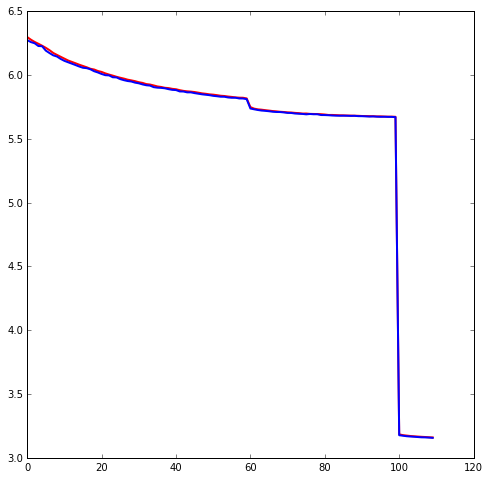

In [266]:
plt.figure(figsize=(8,8))
plt.plot(trainl, 'r', linewidth=2.0)
plt.plot(testl, 'b', linewidth=2.0)
plt.show()

In [19]:
pred_fn = theano.function([yl.input], yl.output)

In [38]:
Xtest, ytest = gen_dataset(500, (100,100))

In [51]:
tmp = pred_fn(X[:500])

Triangle with confidence: 0.945
0.5


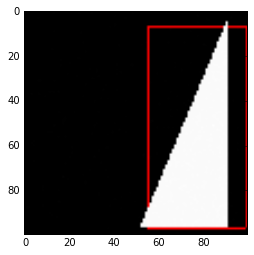

In [52]:
N = np.int_(tmp.shape[0] * np.random.rand())
best, probs, iou = find_best_coords(tmp[N], (100,100))
plt.imshow(draw_coords(X[N,0], best), 'gray')
# print find_best_coords(tmp[N], (100,100))
# print y[N,:4]
prb = np.max(probs)
idx = np.argmax(probs)
if idx == 0:
    print('Circle with confidence: %.3f' % prb)
else:
    print('Triangle with confidence: %.3f' % prb)
print iou

In [22]:
def find_best_coords(output, shape):
    idx = np.argmax(output[[4,9],:,:])
    coord = np.unravel_index(idx, (2,2,2))
    best = np.copy(output[coord[0] * 5:coord[0]*5 + 4, coord[1], coord[2]])
    best[0] += float(coord[1]) / 2
    best[1] += float(coord[2]) / 2
    return best, output[-2:,coord[1],coord[2]], output[[4,9],:,:][coord[0],coord[1],coord[2]]

In [23]:
def draw_coords(im, coord):
    coord[[0,2]] *= im.shape[0]
    coord[[1,3]] *= im.shape[1]
    coord = coord.astype(np.int32)
    im = np.copy(im)
    im = im.reshape(im.shape + (1,))
    im = np.concatenate((im,im,im), axis=2)
    def bound(num, lb, ub):
        return min(ub, max(num,lb))
    ri,rf = bound(coord[0], 0, im.shape[0]-1), bound(coord[0]+coord[2], 0, im.shape[0]-1)
    ci,cf = bound(coord[1], 0, im.shape[1]-1), bound(coord[1]+coord[3], 0, im.shape[1]-1)
    im[ri:rf, ci,0] = 1.0
    im[ri:rf, cf,0] = 1.0
    im[ri, ci:cf,0] = 1.0
    im[rf, ci:cf,0] = 1.0
    return im

In [65]:
a = draw_coords(X[N,0], find_best_coords(tmp[N], (100,100))[0])

In [66]:
a.shape

(100, 100, 3)

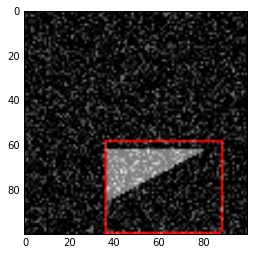

In [67]:
plt.imshow(a)

In [427]:
print find_best_coords(tmp[N], (100,100))

(array([  0, 258,  50,  89]), (1, 0), array([ 0.00714653,  0.99285347]))


In [350]:
np.argmax(tmp[0,[4,9],:,:])

4

In [298]:
np.unravel_index(4, (2,2,2))

(1, 0, 0)

In [300]:
tmp[0,[4,9],:,:][1,0,0]

0.82384296387747824

In [98]:
act_fn = theano.function([input], layers.get_output(le3))

In [99]:
tmp = act_fn(X[:20])

In [104]:
tmp.max()

12.478808450101068

In [125]:
Xtest, ytest = gen_dataset(100, (100,100))

In [159]:
preds = pred_fn(Xtest)

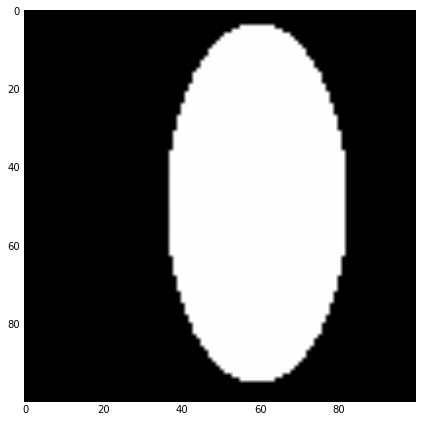

[ 0.5         0.5         0.5         0.5         0.5         0.55200492
  0.5         0.85603257  0.5         0.75187069  0.46587127  0.53412873]
[ 0.5         0.5         0.74491826  0.5         0.85834509  0.5         0.5
  0.5         0.5         0.5         0.49313074  0.50686926]
[ 0.5         0.5         0.5         0.56942442  0.5         0.5         0.5
  0.5         0.5         0.5         0.47401481  0.52598519]
[ 0.5         0.5         0.98718083  0.5417662   0.50982821  0.5         0.5
  1.          0.5         0.5         0.4769725   0.5230275 ]


In [163]:
N = np.int_(Xtest.shape[0] * np.random.rand())
fig = plt.figure(figsize=(7,7))
plt.imshow(Xtest[N,0], 'gray')
plt.show()

for i in range(2):
    for j in range(2):
        print preds[N,:,i,j]

In [132]:
ytest[N]

array([ 12.,  63.,  63.,  26.,   1.,   0.])